In [95]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [96]:
PATH="C:/Users/student/Desktop/lab/competitive-data-science-predict-future-sales/"
train = pd.read_csv(PATH + "sales_train.csv")
test = pd.read_csv(PATH + "test.csv")
shops = pd.read_csv(PATH + "shops.csv")
items = pd.read_csv(PATH + "items.csv")
category = pd.read_csv(PATH + "item_categories.csv")

In [97]:
# PATH="/kaggle/input/competitive-data-science-predict-future-sales/"
# train = pd.read_csv(PATH + "sales_train.csv")
# test = pd.read_csv(PATH + "test.csv")
# shop = pd.read_csv(PATH + "shops.csv")
# items = pd.read_csv(PATH + "items.csv")
# category = pd.read_csv(PATH + "item_categories.csv")

# 노트북 내내 진행되는 간단한 유틸 기능들
A few utility functions used throughout the notebook.

In [98]:
# 다운캐스팅은 부모 클래스가 자식 클래스 객체로 형변환 되는 것.

def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

# EDA

In [99]:
print(train.head(10))
print("=="*10)
print(test.head(10))

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
5  10.01.2013               0       25     2564      349.00           1.0
6  02.01.2013               0       25     2565      549.00           1.0
7  04.01.2013               0       25     2572      239.00           1.0
8  11.01.2013               0       25     2572      299.00           1.0
9  03.01.2013               0       25     2573      299.00           3.0
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
5   5        5     5039
6   6        5    

In [100]:
items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [101]:
print("=="*10)
print(shops.head(10))
print("=="*10)
print(category.head(10))

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
5          Вологда ТРЦ "Мармелад"        5
6      Воронеж (Плехановская, 13)        6
7          Воронеж ТРЦ "Максимир"        7
8    Воронеж ТРЦ Сити-Парк "Град"        8
9               Выездная Торговля        9
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
5      Аксессуары - PSVita                 5
6    Аксессуары - XBOX 360                 6
7    Аксессуары - XBOX ONE                 7
8           Билеты (Цифра)                 8
9          Доставка товара                 9


In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [103]:
print(train.isnull().sum())  #결측치는 없음
print("==="*10)
print(test.isna().sum())
print("==="*10)
print(items.isna().sum())
print("==="*10)
print(shops.isna().sum())
print("==="*10)
print(category.isna().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
ID         0
shop_id    0
item_id    0
dtype: int64
item_name           0
item_id             0
item_category_id    0
dtype: int64
shop_name    0
shop_id      0
dtype: int64
item_category_name    0
item_category_id      0
dtype: int64


In [104]:
shops.value_counts()

shop_name                                        shop_id
!Якутск Орджоникидзе, 56 фран                    0          1
!Якутск ТЦ "Центральный" фран                    1          1
Москва ТЦ "Серебряный Дом"                       32         1
Мытищи ТРК "XL-3"                                33         1
Н.Новгород ТРЦ "РИО"                             34         1
Н.Новгород ТРЦ "Фантастика"                      35         1
Новосибирск ТРЦ "Галерея Новосибирск"            36         1
Новосибирск ТЦ "Мега"                            37         1
Омск ТЦ "Мега"                                   38         1
РостовНаДону ТРК "Мегацентр Горизонт"            39         1
РостовНаДону ТРК "Мегацентр Горизонт" Островной  40         1
РостовНаДону ТЦ "Мега"                           41         1
СПб ТК "Невский Центр"                           42         1
СПб ТК "Сенная"                                  43         1
Самара ТЦ "Мелодия"                              44         1
Самара ТЦ "Па

# Data cleaning

훈련 DF 를 일반적인 데이터 정제 과정을 통해 정제함.

- datetime 연산을 할 수 있게 date feature 을 datetime 타입 객체로 변환

In [105]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

In [106]:
# shop의 중복 id 통합
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
# test 셋에 남아있는 shop_id 만 사용
# 점수를 올리기 위한 일종의 과적합 테크닉
train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]
# training item의 극단적이거나 음수인 가격(또는 판매)값을 제거
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

In [107]:
# item_price, item_cnt_day 로그화하여 분포를 안정시킨 데이터
train["log_item_price"] = np.log1p(train["item_price"])
train["log_item_cnt_day"] = np.log1p(train["item_cnt_day"])

In [108]:
train["item_cnt_day"].value_counts()

1.0      2182677
2.0       159891
3.0        38381
4.0        15894
5.0         8436
6.0         5114
7.0         3263
8.0         2344
9.0         1749
10.0        1473
11.0        1004
12.0         855
13.0         731
14.0         575
15.0         518
16.0         439
17.0         359
18.0         309
20.0         299
19.0         290
21.0         231
22.0         197
24.0         174
23.0         159
25.0         137
26.0         131
30.0         116
27.0         108
28.0         104
31.0          98
32.0          85
29.0          82
33.0          67
34.0          65
35.0          52
37.0          50
36.0          48
41.0          45
40.0          43
39.0          43
38.0          41
44.0          32
42.0          31
46.0          31
43.0          29
45.0          29
50.0          28
49.0          21
48.0          21
52.0          20
47.0          18
51.0          17
61.0          15
53.0          14
100.0         12
55.0          11
80.0          11
64.0          11
62.0          

In [109]:
train["log_item_cnt_day"].value_counts()

0.693147    2182677
1.098612     159891
1.386294      38381
1.609438      15894
1.791759       8436
1.945910       5114
2.079442       3263
2.197225       2344
2.302585       1749
2.397895       1473
2.484907       1004
2.564949        855
2.639057        731
2.708050        575
2.772589        518
2.833213        439
2.890372        359
2.944439        309
3.044522        299
2.995732        290
3.091042        231
3.135494        197
3.218876        174
3.178054        159
3.258097        137
3.295837        131
3.433987        116
3.332205        108
3.367296        104
3.465736         98
3.496508         85
3.401197         82
3.526361         67
3.555348         65
3.583519         52
3.637586         50
3.610918         48
3.737670         45
3.713572         43
3.688879         43
3.663562         41
3.806662         32
3.761200         31
3.850148         31
3.784190         29
3.828641         29
3.931826         28
3.912023         21
3.891820         21
3.970292         20


# Preprocessing

test data는 test month에 등록된 가격들로 shop 과 item의 모든 가능한 조합(데카르트 곱) 인 것으로 보입니다. 이것들의 목표 데이터는 각 shop-item 조합에 따른 총 월매출입니다. train 행렬(matrix)은 이런 구조들을 train 데이터 기간동안 똑같이 복제해 사용하는 형태입니다. feature들이 test 기간동안 만들어질 수 있도록, 테스트 item들은 training set에 마지막에 연결됩니다.   

In [110]:
# train 데이터를 test 데이터와 병합하여 새로운 train data 만들기.
# 점수를 올리기 위한 일종의 과적합 테크닉.

def create_testlike_train(sales_train, test=None):
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

    # sales_train 데이터에 revenue column 추가 
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    sales_train["log_item_revenue_day"] = sales_train["log_item_price"] * sales_train["log_item_cnt_day"]
    # item_id / shop_id 에 따라 item_cnts 와 revenue 를 month level로 집계
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg( #월별, shopid별,itemid별 그룹바이
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"), #pandas.NamedAgg(column, aggfunc) 적용할 칼럼, 적용할 함수
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
        log_item_cnt_month=pd.NamedAgg(column="log_item_cnt_day", aggfunc="sum"),
        log_item_revenue_month=pd.NamedAgg(column="log_item_revenue_day", aggfunc="sum"),
    )

    # Merge the grouped data with the index
    df = df.merge(
        sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"],
    )

    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop("ID",1)

        df = pd.concat([df, test[["date_block_num", "shop_id", "item_id"]]])

    # 혹시 있을지 모르는 달별 데이터의 na 데이터 0으로 대체
    df.item_cnt_month = df.item_cnt_month.fillna(0) 
    df.item_revenue_month = df.item_revenue_month.fillna(0)
    df.log_item_cnt_month = df.log_item_cnt_month.fillna(0)
    df.log_item_revenue_month = df.log_item_revenue_month.fillna(0)

    return df


In [111]:
matrix = create_testlike_train(train, test)
del(test)

KeyboardInterrupt: 

In [ ]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,log_item_cnt_month,log_item_revenue_month
0,0,59,22154,1.0,999.0,0.693147,4.788091
1,0,59,2552,0.0,0.0,0.000000,0.000000
2,0,59,2554,0.0,0.0,0.000000,0.000000
3,0,59,2555,0.0,0.0,0.000000,0.000000
4,0,59,2564,0.0,0.0,0.000000,0.000000


*** 'reduce_mem_usage' 기능은 데이터타입을 다운캐스트 하는데 이는 캐글 노트북 상에서 실행되는 중 메모리 오버플로우가 일어나지 않도록 하기 위해 필수적인 작업입니다. ***

In [ ]:
matrix = reduce_mem_usage(matrix, silent=False)
oldcols = matrix.columns

Memory usage of dataframe is 540.59 MB
Memory usage after optimization is: 219.61 MB
Decreased by 59.4%


# Feature engineering

이 구간에서는 예측 정확성을 위해 임의의 feature 열들이 만들어지고 정렬 속에 추가됩니다.

# Item name groups with fuzzywuzzy
- item 테이블 내의 item 들은 필드 내에서 알파벳 순으로 정렬됩니다. 따라서 비슷한 아이템들은 일반적으로 근처에 배치됩니다. 예를 들어 한 개의 테이블 내의 최초의 두 개의 아이템들은 두 개의 다른 형태의 인터넷 보안을 사용하는 다른 콘솔을 사용한 같은 게임, 'Fuse'를 가리킵니다. 
- 이러한 정렬방식은 비슷한 종류의 아이템을 그룹핑하는데 도움이 됩니다.

In [ ]:
items.query("item_id>3564").head(5)

,item_name,item_id,item_category_id
3565,"Fuse [PS3, английская версия]",3565,19
3566,"Fuse [Xbox 360, английская версия]",3566,23
3567,G Data Internet Security 2013 (1ПК / 1 год) (G...,3567,76
3568,G Data Internet Security 2013 (3ПК / 1 год) (G...,3568,76
3569,GABIN The Best Of Gabin 2CD,3569,55


- 이하의 셀들은 비슷한 아이템들을 루프를 통해 연속적으로 묶는 과정입니다.
- string 타입의 데이터들을 이름의 비슷한 정도를 fuzzywuzzy 라이브러리를 사용하여 측정하고 일치값이 임계값을 초과하는 경우 같은 그룹으로 배정합니다.

In [ ]:
import re #정규표현식 사용모듈

from fuzzywuzzy import fuzz # 문자열 일치에 사용되는 Python 라이브러리


def add_item_name_groups(matrix, train, items, sim_thresh, feature_name="item_name_group"):
    def partialmatchgroups(items, sim_thresh=sim_thresh):
        def strip_brackets(string):
            string = re.sub(r"\(.*?\)", "", string) # () 안의 문자 중 하나와 매치
            string = re.sub(r"\[.*?\]", "", string) # . = 모든 문자, *=반복, 앞의 문자 "." 이 가능한한 적게, 필요한한 계속 확장됨.
            return string  # item_name 안의 러시아어를 분리하기 위한 def

        items = items.copy()
        items["nc"] = items.item_name.apply(strip_brackets)
        items["ncnext"] = np.concatenate((items["nc"].to_numpy()[1:], np.array([""])))

        def partialcompare(s):
            return fuzz.partial_ratio(s["nc"], s["ncnext"])

        items["partialmatch"] = items.apply(partialcompare, axis=1)
        # 그룹 할당
        grp = 0
        for i in range(items.shape[0]):
            items.loc[i, "partialmatchgroup"] = grp
            if items.loc[i, "partialmatch"] < sim_thresh:
                grp += 1
        items = items.drop(columns=["nc", "ncnext", "partialmatch"])
        return items

    items = partialmatchgroups(items)
    items = items.rename(columns={"partialmatchgroup": feature_name})
    items = items.drop(columns="partialmatchgroup", errors="ignore")

    items[feature_name] = items[feature_name].apply(str)
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left")
    train = train.merge(items[["item_id", feature_name]], on="item_id", how="left")
    return matrix, train


matrix, train = add_item_name_groups(matrix, train, items, 65)

c:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,log_item_cnt_month,log_item_revenue_month,item_name_group
0,0,59,22154,1,999.0,0.693147,4.788091,9737
1,0,59,2552,0,0.0,0.000000,0.000000,1085
2,0,59,2554,0,0.0,0.000000,0.000000,1086
3,0,59,2555,0,0.0,0.000000,0.000000,1087
4,0,59,2564,0,0.0,0.000000,0.000000,1092


In [ ]:
matrix = reduce_mem_usage(matrix, silent=False)
gc.collect()

Memory usage of dataframe is 287.19 MB
Memory usage after optimization is: 236.51 MB
Decreased by 17.6%


9

# Music artist / first word of item name
- 이 기능은 music item 들을 item name 에서 3가지 일반적인 패턴(전부 대문자 형태, 제목 사이에 더블스페이스로 구분한 것, .으로 구분한 것)으로 추출한 artist name 에 따라 그룹으로 분류합니다. 

- non-music 카테고리들을 위해서는 대신해 아이템들을 첫번째 단어에 따라 분류합니다.

In [ ]:
# import nltk

In [ ]:
# nltk.download()

In [ ]:
from nltk.corpus import stopwords

In [ ]:
def add_first_word_features(matrix, items=items, feature_name="artist_name_or_first_word"):
    #  이 기능은 음악 카테고리에 대한 아티스트 이름을 추출하여 특성으로 추가합니다.
    def extract_artist(st):
        st = st.strip()
        if st.startswith("V/A"):
            artist = "V/A"
        elif st.startswith("СБ"):
            artist = "СБ"
        else:
            # 이중 공백 또는 모두 대문자 패턴을 사용하여 아티스트 이름을 검색합니다.
            mus_artist_dubspace = re.compile(r".{2,}?(?=\s{2,})")
            match_dubspace = mus_artist_dubspace.match(st)
            mus_artist_capsonly = re.compile(r"^([^a-zа-я]+\s)+")
            match_capsonly = mus_artist_capsonly.match(st)
            candidates = [match_dubspace, match_capsonly]
            candidates = [m[0] for m in candidates if m is not None]
            # 가끔 패턴 중 하나가 쓸데없는 걸 추가로 잡아서, 제일 짧은 걸 선택하도록 합니다.
            if len(candidates):
                artist = min(candidates, key=len)
            else:
                # 이전 패턴 중 어느 것도 찾지 못한 경우 도트-스페이스 패턴을 사용합니다.
                mus_artist_dotspace = re.compile(r".{2,}?(?=\.\s)")
                match = mus_artist_dotspace.match(st)
                if match:
                    artist = match[0]
                else:
                    artist = ""
        artist = artist.upper()
        artist = re.sub(r"[^A-ZА-Я ]||\bTHE\b", "", artist)
        artist = re.sub(r"\s{2,}", " ", artist)
        artist = artist.strip()
        return artist

    items = items.copy()
    all_stopwords = stopwords.words("russian")
    all_stopwords = all_stopwords + stopwords.words("english")

    def first_word(string):
        # 이 함수는 특수 문자 문자열, 초과 공백 및 불용어를 정리한 다음 첫 번째 단어를 추출합니다.
        string = re.sub(r"[^\w\s]", "", string)
        string = re.sub(r"\s{2,}", " ", string)
        tokens = string.lower().split()
        tokens = [t for t in tokens if t not in all_stopwords]
        token = tokens[0] if len(tokens) > 0 else ""
        return token

    music_categories = [55, 56, 57, 58, 59, 60]
    items.loc[items.item_category_id.isin(music_categories), feature_name] = items.loc[
        items.item_category_id.isin(music_categories), "item_name"
    ].apply(extract_artist)
    items.loc[items[feature_name] == "", feature_name] = "other music"
    items.loc[~items.item_category_id.isin(music_categories), feature_name] = items.loc[
        ~items.item_category_id.isin(music_categories), "item_name"
    ].apply(first_word)
    items.loc[items[feature_name] == "", feature_name] = "other non-music"
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left",)
    return matrix


matrix = add_first_word_features(
    matrix, items=items, feature_name="artist_name_or_first_word"
)

# 아이템 이름 길이를 특징(feature)으로 변환
- 아이템 이름 길이 특징은 매우 성능이 좋습니다. 아마도 비슷한 아이템들은 비슷한 이름 길이를 가지고 있기 때문일 것입니다. 
- 이 방법은 그냥 데이터와 정제된 데이터 모두에서 뛰어난 효과를 발휘했습니다. 이 방법은 항목간의 애매한 유사성들에 대한 정보를 포함하고 있습니다.

In [ ]:
import re
def clean_item_name(string):
    # 괄호로 묶여있는 용어들 및 특수문자와 공백을 제거합니다.
    string = re.sub(r"\[.*?\]", "", string)
    string = re.sub(r"\(.*?\)", "", string)
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

items["item_name_cleaned_length"] = items["item_name"].apply(clean_item_name).apply(len)
items["item_name_length"] = items["item_name"].apply(len)
matrix = matrix.merge(items[['item_id', 'item_name_length', 'item_name_cleaned_length']], how='left', on='item_id')
items = items.drop(columns=['item_name_length', 'item_name_cleaned_length'])

In [ ]:
print("Created name features")
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

Created name features


In [ ]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,log_item_cnt_month,log_item_revenue_month,item_name_group,artist_name_or_first_word,item_name_length,item_name_cleaned_length
0,0,59,22154,1,999.0,0.693147,4.788091,9737,4950,17,13
1,0,59,2552,0,0.0,0.000000,0.000000,1085,384,40,38
2,0,59,2554,0,0.0,0.000000,0.000000,1086,384,40,38
3,0,59,2555,0,0.0,0.000000,0.000000,1087,384,39,32
4,0,59,2564,0,0.0,0.000000,0.000000,1092,384,50,43


# Time features
- 일자와 월별 정확도(resolution) time feature 들은 training 데이터프레임에서 만들어졌습니다. 예를 들어 각 품목이 팔린 첫날과 마지막날 같은 데이터 말입니다.
- 각 항목의 첫번째 판매 이후의 시간은 sales-per-day 의 평균을 나타내는 feature(= ("item_cnt_day_avg") column)을 만드는데 사용됩니다. 
- 이 항목은 한 달이 지나기 전에 팔렸거나 해서 이전 달 전체 기간 내내 동안은 살 수 없었던 데이터들을 정정하는데 도움이 됩니다. 

In [ ]:
def add_time_features(m, train, correct_item_cnt_day=False):
    from pandas.tseries.offsets import Day, MonthBegin, MonthEnd

    def item_shop_age_months(m):
        m["item_age"] = m.groupby("item_id")["date_block_num"].transform(
            lambda x: x - x.min()
        )
        # 판매는 12개월 후에 정체되는 경향이 있음
        m["new_item"] = m["item_age"] == 0
        m["new_item"] = m["new_item"].astype("int8")
        m["shop_age"] = (
            m.groupby("shop_id")["date_block_num"]
            .transform(lambda x: x - x.min())
            .astype("int8")
        )
        return m

    # 테스트 월에 대한 더미값을 추가하여 feature 들이 제대로 생성될 수 있게 함
    dummies = m.loc[m.date_block_num == 34, ["date_block_num", "shop_id", "item_id"]]
    dummies = dummies.assign(
        date=pd.to_datetime("2015-11-30"), item_price=1, item_cnt_day=0, item_revenue_day=0,
    )
    train = pd.concat([train, dummies])
    del dummies

    month_last_day = train.groupby("date_block_num").date.max().rename("month_last_day")
    month_last_day[~month_last_day.dt.is_month_end] = (
        month_last_day[~month_last_day.dt.is_month_end] + MonthEnd()
    )
    month_first_day = train.groupby("date_block_num").date.min().rename("month_first_day")
    month_first_day[~month_first_day.dt.is_month_start] = (
        month_first_day[~month_first_day.dt.is_month_start] - MonthBegin()
    )
    month_length = (month_last_day - month_first_day + Day()).rename("month_length")
    first_shop_date = train.groupby("shop_id").date.min().rename("first_shop_date")
    first_item_date = train.groupby("item_id").date.min().rename("first_item_date")
    first_shop_item_date = (
        train.groupby(["shop_id", "item_id"]).date.min().rename("first_shop_item_date")
    )
    first_item_name_group_date = (
        train.groupby("item_name_group").date.min().rename("first_name_group_date")
    )

    m = m.merge(month_first_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_last_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_length, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(first_shop_date, left_on="shop_id", right_index=True, how="left")
    m = m.merge(first_item_date, left_on="item_id", right_index=True, how="left")
    m = m.merge(
        first_shop_item_date, left_on=["shop_id", "item_id"], right_index=True, how="left"
    )
    m = m.merge(
        first_item_name_group_date, left_on="item_name_group", right_index=True, how="left"
    )

    # 매달 상품이 얼마나 오래 진열되어있었는지 계산하고 이걸 일일 평균 상품판매량을 계산하는데 사용
    m["shop_open_days"] = m["month_last_day"] - m["first_shop_date"] + Day()
    m["item_first_sale_days"] = m["month_last_day"] - m["first_item_date"] + Day()
    m["item_in_shop_days"] = (
        m[["shop_open_days", "item_first_sale_days", "month_length"]].min(axis=1).dt.days
    )
    m = m.drop(columns="item_first_sale_days")
    m["item_cnt_day_avg"] = m["item_cnt_month"] / m["item_in_shop_days"]  # 일일 판매량 = 아이템이 상점에 있던 날들로 월별 판매량을 나눔
    m["log_item_cnt_day_avg"] = m["log_item_cnt_month"] / m["item_in_shop_days"]
    m["month_length"] = m["month_length"].dt.days

    # 시작월로부터 시차를 계산하여 lag 없이 특성으로 사용될 수 있도록 처리
    m["shop_open_days"] = m["month_first_day"] - m["first_shop_date"]
    m["first_item_sale_days"] = m["month_first_day"] - m["first_item_date"]
    m["first_shop_item_sale_days"] = m["month_first_day"] - m["first_shop_item_date"]
    m["first_name_group_sale_days"] = m["month_first_day"] - m["first_name_group_date"]
    m["shop_open_days"] = m["shop_open_days"].dt.days.fillna(0).clip(lower=0)     # numpy.clip(array, min, max)  array 내의 element들에 대해서 min 값 보다 작은 값들을 min값으로 바꿔주고 max 값 보다 큰 값들을 max값으로 바꿔주는 함수
    m["first_item_sale_days"] = (
        m["first_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_shop_item_sale_days"] = (
        m["first_shop_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_name_group_sale_days"] = (
        m["first_name_group_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )

    # 마지막 판매로부터의 날짜 추가
    def last_sale_days(matrix):
        last_shop_item_dates = []
        for dbn in range(1, 35):
            lsid_temp = (
                train.query(f"date_block_num<{dbn}")
                .groupby(["shop_id", "item_id"])
                .date.max()
                .rename("last_shop_item_sale_date")
                .reset_index()
            )
            lsid_temp["date_block_num"] = dbn
            last_shop_item_dates.append(lsid_temp)

        last_shop_item_dates = pd.concat(last_shop_item_dates)
        matrix = matrix.merge(
            last_shop_item_dates, on=["date_block_num", "shop_id", "item_id"], how="left"
        )

        def days_since_last_feat(m, feat_name, date_feat_name, missingval):
            m[feat_name] = (m["month_first_day"] - m[date_feat_name]).dt.days
            m.loc[m[feat_name] > 2000, feat_name] = missingval   # 차가 2000이 넘으면 결측치로 처리
            m.loc[m[feat_name].isna(), feat_name] = missingval
            return m

        matrix = days_since_last_feat(
            matrix, "last_shop_item_sale_days", "last_shop_item_sale_date", 9999
        )

        matrix = matrix.drop(columns=["last_shop_item_sale_date"])
        return matrix

    m = last_sale_days(m)
    # 월 지표
    m["month"] = m["month_first_day"].dt.month
    # 월 지표에 분기 지표 추가
    m["quarter"] = m["month_first_day"].dt.quarter
    
    m = m.drop(
        columns=[
            "first_day",
            "month_first_day",
            "month_last_day",
            "first_shop_date",
            "first_item_date",
            "first_name_group_date",
            "item_in_shop_days",
            "first_shop_item_date",
            "month_length",
        ],
        errors="ignore",
    )

    m = item_shop_age_months(m)

    if correct_item_cnt_day == True:
        m["item_cnt_month_original"] = m["item_cnt_month"]
        m["item_cnt_month"] = m["item_cnt_day_avg"] * m["month_length"]
        m["log_item_cnt_month"] = m["log_item_cnt_day_avg"] * m["month_length"]

    return m

In [ ]:
matrix = add_time_features(matrix, train, False)
print("Time features created")

Time features created


In [ ]:
matrix.head().T # 절기 feature 추가

,0,1,2,3,4
date_block_num,0.000000,0.0,0.0,0.0,0.0
shop_id,59.000000,59.0,59.0,59.0,59.0
item_id,22154.000000,2552.0,2554.0,2555.0,2564.0
item_cnt_month,1.000000,0.0,0.0,0.0,0.0
item_revenue_month,999.000000,0.0,0.0,0.0,0.0
log_item_cnt_month,0.693147,0.0,0.0,0.0,0.0
log_item_revenue_month,4.788091,0.0,0.0,0.0,0.0
item_name_group,9737.000000,1085.0,1086.0,1087.0,1092.0
artist_name_or_first_word,4950.000000,384.0,384.0,384.0,384.0
item_name_length,17.000000,40.0,40.0,39.0,50.0


In [ ]:
matrix = reduce_mem_usage(matrix, silent=False)

Memory usage of dataframe is 886.90 MB
Memory usage after optimization is: 481.46 MB
Decreased by 45.7%


# Price features
전달 팔린 item 들의 가격과 관련된 다른 아이템들의 가격들입니다. 

In [ ]:
def add_price_features(matrix, train):
    # 훈련 데이터프레임으로부터 월별 평균 가격을 구함
    price_features = train.groupby(["date_block_num", "item_id"]).item_price.mean()
    price_features = pd.DataFrame(price_features)
    price_features = price_features.reset_index()
    # 월별 평균 카테고리 가격의 정규화 차이 계산
    price_features = price_features.merge(
        items[["item_id", "item_category_id"]], how="left", on="item_id"
    )
    price_features["norm_diff_cat_price"] = price_features.groupby(
        ["date_block_num", "item_category_id"]
    )["item_price"].transform(lambda x: (x - x.mean()) / x.std())  # 정규화 작업, 기존에는 x.std  대신 x.mean()이 들어있었음. 왜?
    price_features["log_norm_diff_cat_price"] = price_features.groupby(
        ["date_block_num", "item_category_id"]
    )["item_price"].transform(lambda x: np.log1p((x - x.mean()) / x.std())) 

    # 필수적인 feature 들만 남김
    price_features = price_features[
        [
            "date_block_num",
            "item_id",
            "item_price",
            "norm_diff_cat_price",
            "log_norm_diff_cat_price",
        ]
    ]

    features = [
        "item_price",
        "norm_diff_cat_price",
        "log_norm_diff_cat_price",
    ]
    newnames = ["last_" + f for f in features]
    aggs = {f: "last" for f in features}
    renames = {f: "last_" + f for f in features}
    features = []
    for dbn in range(1, 35):
        f_temp = (
            price_features.query(f"date_block_num<{dbn}")
            .groupby("item_id")
            .agg(aggs)
            .rename(columns=renames)
        )
        f_temp["date_block_num"] = dbn
        features.append(f_temp)
    features = pd.concat(features).reset_index()
    matrix = matrix.merge(features, on=["date_block_num", "item_id"], how="left")
    return matrix

In [ ]:
matrix = add_price_features(matrix, train)
del(train)

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,log_item_cnt_month,log_item_revenue_month,item_name_group,artist_name_or_first_word,item_name_length,...,first_name_group_sale_days,last_shop_item_sale_days,month,quarter,item_age,new_item,shop_age,last_item_price,last_norm_diff_cat_price,last_log_norm_diff_cat_price
0,0,59,22154,1,999.0,0.693147,4.788091,9737,4950,17,...,9999,9999,1,1,0,1,0,NaN,NaN,NaN
1,0,59,2552,0,0.0,0.000000,0.000000,1085,384,40,...,9999,9999,1,1,0,1,0,NaN,NaN,NaN
2,0,59,2554,0,0.0,0.000000,0.000000,1086,384,40,...,9999,9999,1,1,0,1,0,NaN,NaN,NaN
3,0,59,2555,0,0.0,0.000000,0.000000,1087,384,39,...,9999,9999,1,1,0,1,0,NaN,NaN,NaN
4,0,59,2564,0,0.0,0.000000,0.000000,1092,384,50,...,9999,9999,1,1,0,1,0,NaN,NaN,NaN


In [ ]:
matrix.head().T

,0,1,2,3,4
date_block_num,0.000000,0.0,0.0,0.0,0.0
shop_id,59.000000,59.0,59.0,59.0,59.0
item_id,22154.000000,2552.0,2554.0,2555.0,2564.0
item_cnt_month,1.000000,0.0,0.0,0.0,0.0
item_revenue_month,999.000000,0.0,0.0,0.0,0.0
log_item_cnt_month,0.693147,0.0,0.0,0.0,0.0
log_item_revenue_month,4.788091,0.0,0.0,0.0,0.0
item_name_group,9737.000000,1085.0,1086.0,1087.0,1092.0
artist_name_or_first_word,4950.000000,384.0,384.0,384.0,384.0
item_name_length,17.000000,40.0,40.0,39.0,50.0


# Item category features  
- 주어진 아이템 카테고리에 더해 두 개의 추가적인 카테고리 그룹을 더해줬습니다. 
- 상위 그룹(예: "games", "music")과 플랫폼(예:  "PS4", "mp3")

In [ ]:
matrix = matrix.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

platform_map = {
    0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 8, 10: 1, 11: 2,
    12: 3, 13: 4, 14: 5, 15: 6, 16: 7, 17: 8, 18: 1, 19: 2, 20: 3, 21: 4, 22: 5,
    23: 6, 24: 7, 25: 8, 26: 9, 27: 10, 28: 0, 29: 0, 30: 0, 31: 0, 32: 8, 33: 11,
    34: 11, 35: 3, 36: 0, 37: 12, 38: 12, 39: 12, 40: 13, 41: 13, 42: 14, 43: 15,
    44: 15, 45: 15, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14, 51: 14, 52: 14, 53: 14,
    54: 8, 55: 16, 56: 16, 57: 17, 58: 18, 59: 13, 60: 16, 61: 8, 62: 8, 63: 8, 64: 8,
    65: 8, 66: 8, 67: 8, 68: 8, 69: 8, 70: 8, 71: 8, 72: 8, 73: 0, 74: 10, 75: 0,
    76: 0, 77: 0, 78: 0, 79: 8, 80: 8, 81: 8, 82: 8, 83: 8
}
matrix['platform_id'] = matrix['item_category_id'].map(platform_map)

supercat_map = {
    0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 1, 11: 1, 12: 1,
    13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3,
    24: 3, 25: 0, 26: 2, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 2, 33: 2, 34: 2,
    35: 2, 36: 2, 37: 4, 38: 4, 39: 4, 40: 4, 41: 4, 42: 5, 43: 5, 44: 5, 45: 5,
    46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 6, 56: 6,
    57: 6, 58: 6, 59: 6, 60: 6, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0,
    68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 7, 74: 7, 75: 7, 76: 7, 77: 7, 78: 7,
    79: 2, 80: 2, 81: 0, 82: 0, 83: 0
}
matrix['supercategory_id'] = matrix['item_category_id'].map(supercat_map)

# Shop city
(from https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

기존 문서가 참조한 다른 문서의 특성 값입니다.

항목의 설명을 보면 각각의 shop_name 이 각자의 도시 이름으로 시작하고 category 가 종류와 하위종류를 이름에 포함 중이라고 하는군요.
하단의 코드는 이 특성을 분리하고 저장하는 코드입니다. 

In [ ]:
def add_city_codes(matrix, shops):
    shops.loc[
        shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
    ] = 'СергиевПосад ТЦ "7Я"'
    shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
    shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
    shops["city_code"] = shops["city"].factorize()[0]
    shop_labels = shops[["shop_id", "city_code"]]
    matrix = matrix.merge(shop_labels, on='shop_id', how='left')
    return matrix

matrix = add_city_codes(matrix, shops)
del(shops)

# Shop and item 카테고리 군집화(category clustering)

- shop 과 item 카테고리들은 sales 상태에 따라 군집화되어 있습니다.
- 하단의 function 은 shop 과 item 카테고리들에 대해  주성분분석 분해 및 클러스터링(군집화)을 실시하고 그 결과를 그립니다. 

- 각 PCA 차원에 의해 설명되는 아이템 간의 설명 분산 비율이 표시되고 개별 아이템들이 PCA 차원의 점수에 따라 표시되고 군집그룹에 따라 색깔이 배정됩니다.

- 파라미터의 다양한 값에 대한 'The silhouette score' (군집화 수준 점수) 역시 표시됩니다. 이런 그림들은 군집화 정도(군집화 그룹 수)를 결정하는데 사용됩니다. 

- shop 과 item 카테고리들에 대해 발생하는 차이의 80% 이상이 단일차원에서 발생합니다. 이는 차이가 주로 비율보다는 크기에 의해 발생한다는 사실을 나타냅니다. 항목 구성요소점수 그림은 클러스터링이 대부분의 항목을 포함하는 큰 군집과 이상값 항목을 몇 개 포함하는 작은 몇 개의 군집이 존재함을 나타냅니다. 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


def cluster_feature(matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
    start_month = 20
    end_month = 32
    pt = matrix.query(f"date_block_num>{start_month} & date_block_num<={end_month}")
    if exclude is not None:
        pt = matrix[~matrix[clust_feature].isin(exclude)]
    pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
    pt = pt.transpose()
    pca = PCA(n_components=10)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    # Plot PCA explained variance
    sns.set_theme()
    features = list(range(pca.n_components_))
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
#     ax.bar(features, pca.explained_variance_ratio_, color="black")
    sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
    plt.title("Variance by PCA components")
    plt.xlabel("component")
    plt.ylabel("explained variance")
    plt.xticks(features)

    scorelist = []
    nrange = range(2, 10)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        labels = clusterer.fit_predict(components)
        silscore = silhouette_score(pt, labels)
        scorelist.append(silscore)
    ax = fig.add_subplot(122)
    sns.lineplot(x=nrange, y=scorelist, ax=ax)
    plt.title("Clustering quality by number of clusters")
    plt.xlabel("n clusters")
    plt.ylabel("silhouette score")

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
    plt.title("Items by cluster")
    plt.xlabel("component 1 score")
    plt.ylabel("component 2 score")
    for i, txt in enumerate(pt.index.to_list()):
        ax.annotate(str(txt), (x[i], y[i]))
    groups = {}
    for i, s in enumerate(pt.index):
        groups[s] = labels[i]
    return groups

- item 카테고리들은 해당 연도의 매월 평균 판매량에 따라 군집합니다. 
- 주성분그림 그려보면 3 개의 카테고리가 이와 관련하여 이상값을 가지고 있음을 나타냅니다.


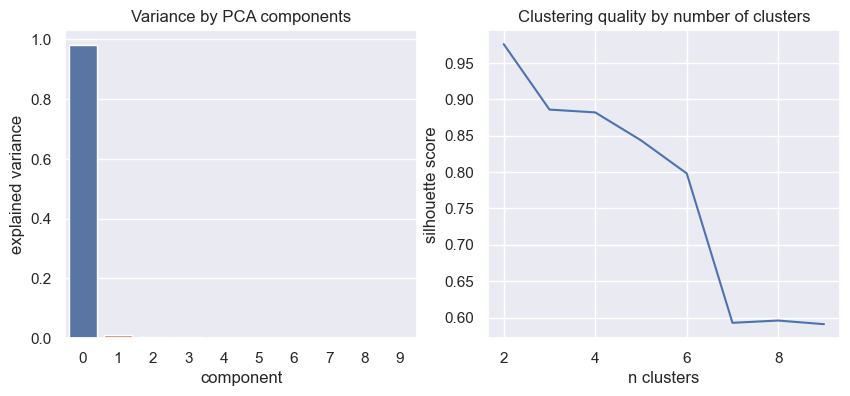

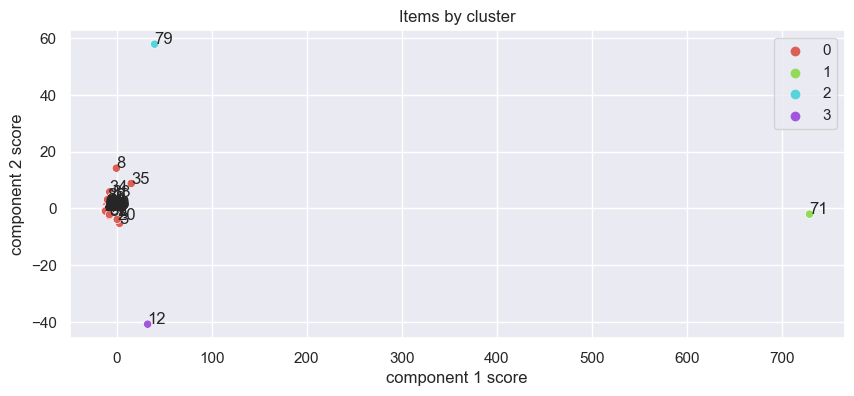

In [ ]:
category_group_dict = cluster_feature(matrix, 'item_cnt_month', 'item_category_id', 'date_block_num', n_components=2, n_clusters=4, aggfunc="mean", exclude =[])
matrix['category_cluster'] = matrix['item_category_id'].map(category_group_dict)

- Shop 은 각 item category의 총합 판매량으로 군집합니다.(=나뉘어져 그룹화됩니다.) 주성분그림를 그려보면 shop은 그들의 판매량에 의해 주로 차이를 가집니다. 
- Shop 31은 판매량으로 인해 이상치로 판정됩니다. Shop 12와 55는 서로 다른 (온라인 판매 전용) item을 팔고 있기 때문에 직교차원에서 이상치로 판정됩니다. (=서로 독립적이고 관련이 없습니다.)

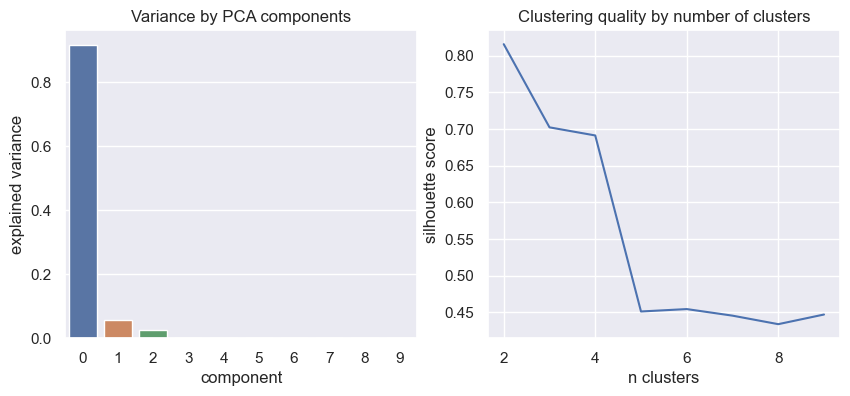

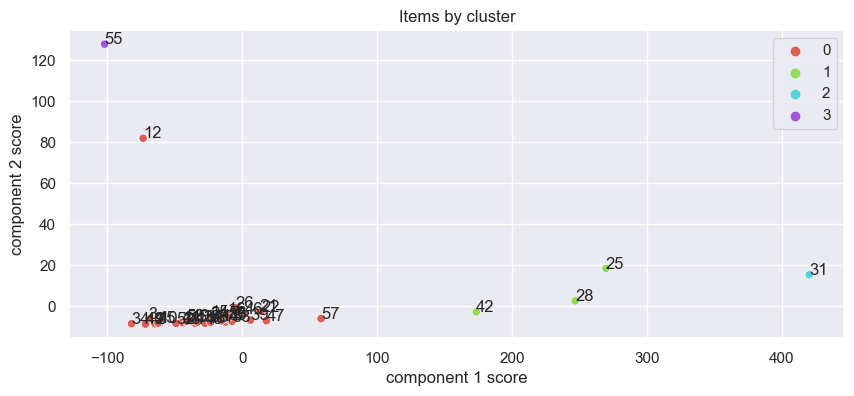

In [ ]:
shop_group_dict = cluster_feature(matrix, 'item_cnt_month', 'shop_id', 'item_category_id', n_components=4, n_clusters=4, aggfunc="mean", exclude=[36])
shop_group_dict[36] = shop_group_dict[37]  # Shop36 은 따로 더할 것인데 왜냐하면 한 달치 데이터만 가지고 있기 때문입니다.
matrix['shop_cluster'] = matrix['shop_id'].map(shop_group_dict)

In [ ]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)  # 메모리 절약을 위해 이 다운캐스트 함수를 자주 사용하세요.

# 고유 item 수에 의한 features
 
- (These features count the number of unique items sharing the same value of a grouping feature or set of features as the current item in the current month)
이 특성들은 이번 달의 현재 항목과 동일한 그룹화 특성 또는 특성 집합 값을 공유하는 고유 항목의 수를 계산합니다.

- 이는 일종의 데이터 유출로 여겨질 수 있습니다, 각 달의 item set이 예측한 달에 팔렸을지 안 팔렸을지 미리 알 수 없는 것처럼 말입니다.

In [ ]:
def uniques(matrix, groupers, name, limitation=None):
    if limitation is not None:
        s = (
            matrix.query(limitation)
            .groupby(groupers)
            .item_id.nunique()
            .rename(name)
            .reset_index()
        )
    else:
        s = matrix.groupby(groupers).item_id.nunique().rename(name).reset_index()
    matrix = matrix.merge(s, on=groupers, how="left")
    matrix[name] = matrix[name].fillna(0)
    return matrix


matrix = uniques(matrix, ["date_block_num"], "unique_items_month")

matrix = uniques(matrix, ["date_block_num", "item_name_group"], "name_group_unique_month")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_name_group"],
    "name_group_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(
    matrix, ["date_block_num", "artist_name_or_first_word"], "first_word_unique_month"
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "artist_name_or_first_word"],
    "first_word_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(matrix, ["date_block_num", "item_category_id"], "unique_items_cat")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id"],
    "new_items_cat",
    limitation="new_item==True",
)
matrix = uniques(matrix, ["date_block_num"], "new_items_month", limitation="new_item==True")

matrix["cat_items_proportion"] = matrix["unique_items_cat"] / matrix["unique_items_month"]
matrix["name_group_new_proportion_month"] = (
    matrix["name_group_new_unique_month"] / matrix["name_group_unique_month"]
)

matrix = matrix.drop(columns=["unique_items_month", "name_group_unique_month"])

In [ ]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# 집계량 퍼센트화   
- 이는 Pandas 패키지의 pct_change 메서드를 사용해서 특정 그룹의 특정 시간대에 대한 평균 판매 횟수의 비율적 변화를 계산합니다. 예를 들어 '지난 2개월 간 특정 item의 평균판매수의 증가/변화 에 따른 내용' 같이요. 

In [ ]:
def add_pct_change(
    matrix,
    group_feats,
    target="item_cnt_month",
    aggfunc="mean",
    periods=1,
    lag=1,
    clip_value=None,
):
    periods = list_if_not(periods, int)
    group_feats = list_if_not(group_feats)
    group_feats_full = ["date_block_num"] + group_feats
    dat = matrix.pivot_table(
        index=group_feats + ["date_block_num"],
        values=target,
        aggfunc=aggfunc,
        fill_value=0,
        dropna=False,
    ).astype("float32")
    for g in group_feats:
        firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
        dat = dat.merge(firsts, left_on=g, right_index=True, how="left")
        dat.loc[dat.index.get_level_values("date_block_num") < dat["firsts"], target] = float(
            "nan"
        )
        del dat["firsts"]
    for period in periods:
        feat_name = "_".join(
            group_feats + [target] + [aggfunc] + ["delta"] + [str(period)] + [f"lag_{lag}"]
        )
        print(f"Adding feature {feat_name}")
        dat = (
            dat.groupby(group_feats)[target]
            .transform(lambda x: x.pct_change(periods=period, fill_method="pad")) #pct change 는 pandas 의 method 로 이전 분기와의 percent change 를 나타냄
            .rename(feat_name)
        )
        if clip_value is not None:
            dat = dat.clip(lower=-clip_value, upper=clip_value)
    dat = dat.reset_index()
    dat["date_block_num"] += lag
    matrix = matrix.merge(dat, on=["date_block_num"] + group_feats, how="left")
    matrix[feat_name] = reduce_mem_usage(matrix[feat_name])
    return matrix

In [ ]:
matrix = add_pct_change(matrix, ["item_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_name_group"], "item_cnt_month", clip_value=3)
# Delta 1 feature lag 를 12로 놓는 것은, 계절적 영향을 캐치하기 위한 것입니다.
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", lag=12, clip_value=3,)
gc.collect()

Adding feature item_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_name_group_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_12


5

In [ ]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)


# +)Window aggregation

- 전체 데이터의 볼륨이 클 경우 이를 윈도우 단위로 잘라서 처리할 수 있는 방법이 있는데, 예를 들어 10분 단위로 데이터를 처리해서, 10분 단위로 최소/최대 값을 구하거나 또는 10분 단위로 어떤 값의 평균값을 대표값으로 사용하는 것들이 이에 해당한다. 

- 일반적으로 입력값은 (entity, timestamp, value) 형태가 되며, 전처리된 출력 값은 다음과 같이. (entity, time_index, aggregated_value_over_time_window) 엔터티(피쳐)에 대해서 윈도우별로 처리된 값을 저장하는 형태가 된다.  보통 이런 window aggregation 방식은 리얼 타임 스트리밍 데이터에서 시간 윈도우 단위로 데이터를 처리하는 경우에 많이 사용이 되며, Apache Beam과 같은 스트리밍 프레임워크를 이용하여 구현한다. 

# Windowed aggregates

+) 일정 시간간격동안의 간격 = window

일종의 time filter 라고 보는 게 편하겠습니다. ex)window_size = n # n일간의 데이터를 갖고 다음 단일 타겟을 예측

noise(오차)를 줄이기 위해 특정 윈도우들을 집계한 특성입니다. 

접근가능한 window는 확장(=앞선 모든 시점들), 롤링(=동일한 가중치가 부여된 고정된 각 시점에 대한 가중치들) 및 지수가중평균이 있습니다.

A note about feature names: these are set automatically according to the pattern < grouping features > - < aggregated features > - < monthly aggregation function > - < window type > , where < window type > is either "rolling - < window aggregation function > - win - < window length in months >" for square rolling windows, "expanding - < window aggregation function >" for expanding windows, and "ewm_hl - < decay rate in terms of half-life > for exponential weighted means, all connected by underscores.

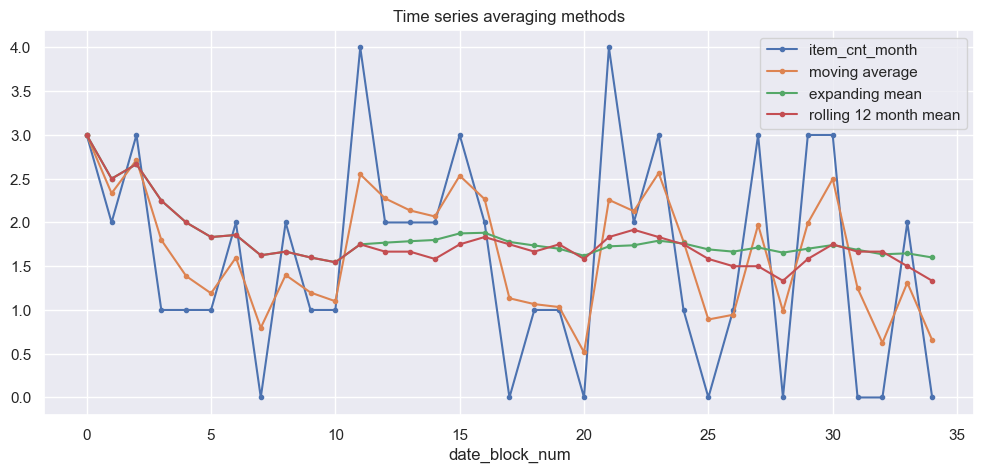

In [ ]:
shop_id = 16
item_id = 482
im = matrix.query(f"shop_id=={shop_id} & item_id=={item_id}")[['date_block_num', 'item_cnt_month']]
im['moving average'] = im['item_cnt_month'].ewm(halflife=1).mean()
im['expanding mean'] = im['item_cnt_month'].expanding().mean()
im['rolling 12 month mean'] = im['item_cnt_month'].rolling(window=12, min_periods=1).mean()
im = im.set_index('date_block_num')
ax = im.plot(figsize=(12,5), marker='.', title='Time series averaging methods')

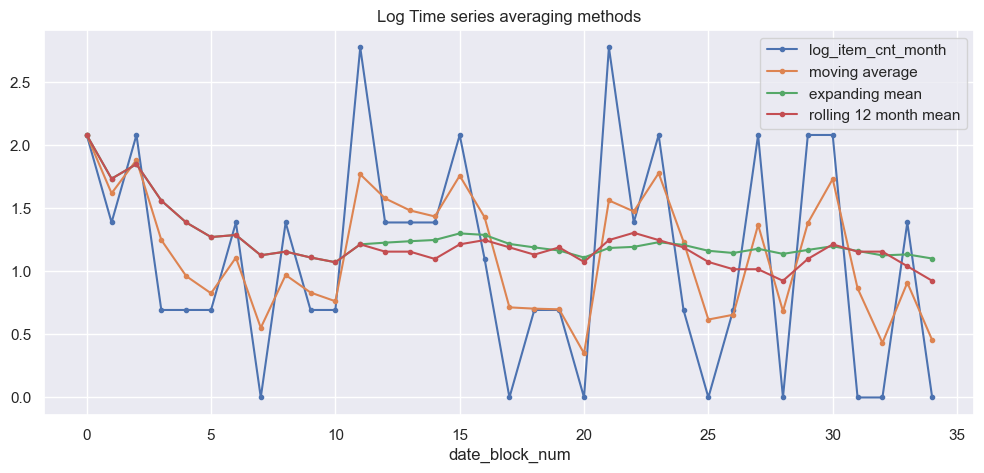

In [ ]:
shop_id = 16
item_id = 482
im = matrix.query(f"shop_id=={shop_id} & item_id=={item_id}")[['date_block_num', 'log_item_cnt_month']]
im['moving average'] = im['log_item_cnt_month'].ewm(halflife=1).mean()
im['expanding mean'] = im['log_item_cnt_month'].expanding().mean()
im['rolling 12 month mean'] = im['log_item_cnt_month'].rolling(window=12, min_periods=1).mean()
im = im.set_index('date_block_num')
ax = im.plot(figsize=(12,5), marker='.', title='Log Time series averaging methods')

In [ ]:
matrix.item_cnt_month.value_counts()

0      7524078
1       878475
2       220928
3        86008
4        44556
        ...   
766          1
528          1
268          1
423          1
461          1
Name: item_cnt_month, Length: 407, dtype: int64

In [ ]:
matrix.log_item_cnt_month.value_counts()

0.000000     7524078
0.693147      878475
1.386294      208874
2.079442       72545
2.772589       31633
              ...   
74.657448          1
11.282001          1
41.996780          1
35.079456          1
12.946408          1
Name: log_item_cnt_month, Length: 4164, dtype: int64

In [ ]:
def add_rolling_stats(
    matrix,
    features,
    window=12,
    kind="rolling",
    argfeat="item_cnt_month",
    aggfunc="mean",
    rolling_aggfunc="mean",
    dtype="float16",
    reshape_source=True,
    lag_offset=0,
):
    def rolling_stat(
        matrix,
        source,
        feats,
        feat_name,
        window=12,
        argfeat="item_cnt_month",
        aggfunc="mean",
        dtype=dtype,
        lag_offset=0,
    ):
        # 특정 기능을 기준으로 그룹화하여 소스 테이블의 윈도우 섹션에 대해 통계치를 계산
        store = []
        for i in range(2 + lag_offset, 35 + lag_offset):
            if len(feats) > 0:
                mes = (
                    source[source.date_block_num.isin(range(max([i - window, 0]), i))]
                    .groupby(feats)[argfeat]
                    .agg(aggfunc)
                    .astype(dtype)
                    .rename(feat_name)
                    .reset_index()
                )
            else:
                mes = {}
                mes[feat_name] = (
                    source.loc[
                        source.date_block_num.isin(range(max([i - window, 0]), i)), argfeat
                    ]
                    .agg(aggfunc)
                    .astype(dtype)
                )
                mes = pd.DataFrame(data=mes, index=[i])
            mes["date_block_num"] = i - lag_offset
            store.append(mes)
        store = pd.concat(store)
        matrix = matrix.merge(store, on=feats + ["date_block_num"], how="left")
        return matrix

    """ 윈도우 기능을 사용할 때 물건이 팔리지 않았을 경우 올바르게 0으로 기록되는 대신 스킵되어 결측치로서 기록되는 문제를 확인했습니다. 
    pivot table을 만들면 0이 채워집니다."""
    if (reshape_source == True) or (kind == "ewm"):
        source = matrix.pivot_table(
            index=features + ["date_block_num"],
            values=argfeat,
            aggfunc=aggfunc,
            fill_value=0,
            dropna=False,
        ).astype(dtype)
        for g in features:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            source = source.merge(firsts, left_on=g, right_index=True, how="left")
            # 0으로 취급되기보다 무시될 수 있도록, 상품이 처음 팔리기 전 시점에는 Nan 처리하세요.
            source.loc[
                source.index.get_level_values("date_block_num") < source["firsts"], argfeat
            ] = float("nan")
            del source["firsts"]
        source = source.reset_index()
    else:
        source = matrix

    if kind == "rolling":
        feat_name = (
            f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
        )
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=window,
            argfeat=argfeat,
            aggfunc=rolling_aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "expanding":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=100,
            argfeat=argfeat,
            aggfunc=aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "ewm":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}" #feature 이름 = feature 이름을 가져오고 _ 뒤에 join 할 feature 을 만든 다음 window 크기를 붙여.
        print(f'Creating feature "{feat_name}"')
        source[feat_name] = (
            source.groupby(features)[argfeat]
            .ewm(halflife=window, min_periods=1)
            .agg(rolling_aggfunc)
            .to_numpy(dtype=dtype)
        )
        del source[argfeat]
        #         source = source.reset_index()
        source["date_block_num"] += 1 - lag_offset
        return matrix.merge(source, on=["date_block_num"] + features, how="left")

In [ ]:
def add_rolling_stats_log(
    matrix,
    features,
    window=12,
    kind="rolling",
    argfeat="log_item_cnt_month",
    aggfunc="mean",
    rolling_aggfunc="mean",
    dtype="float16",
    reshape_source=True,
    lag_offset=0,
):
    def rolling_stat(
        matrix,
        source,
        feats,
        feat_name,
        window=12,
        argfeat="log_item_cnt_month",
        aggfunc="mean",
        dtype=dtype,
        lag_offset=0,
    ):
        # 특정 기능을 기준으로 그룹화하여 소스 테이블의 윈도우 섹션에 대해 통계치를 계산
        store = []
        for i in range(2 + lag_offset, 35 + lag_offset):
            if len(feats) > 0:
                mes = (
                    source[source.date_block_num.isin(range(max([i - window, 0]), i))]
                    .groupby(feats)[argfeat]
                    .agg(aggfunc)
                    .astype(dtype)
                    .rename(feat_name)
                    .reset_index()
                )
            else:
                mes = {}
                mes[feat_name] = (
                    source.loc[
                        source.date_block_num.isin(range(max([i - window, 0]), i)), argfeat
                    ]
                    .agg(aggfunc)
                    .astype(dtype)
                )
                mes = pd.DataFrame(data=mes, index=[i])
            mes["date_block_num"] = i - lag_offset
            store.append(mes)
        store = pd.concat(store)
        matrix = matrix.merge(store, on=feats + ["date_block_num"], how="left")
        return matrix

    """ 윈도우 기능을 사용할 때 물건이 팔리지 않았을 경우 올바르게 0으로 기록되는 대신 스킵되어 결측치로서 기록되는 문제를 확인했습니다. 
    pivot table을 만들면 0이 채워집니다."""
    if (reshape_source == True) or (kind == "ewm"):
        source = matrix.pivot_table(
            index=features + ["date_block_num"],
            values=argfeat,
            aggfunc=aggfunc,
            fill_value=0,
            dropna=False,
        ).astype(dtype)
        for g in features:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            source = source.merge(firsts, left_on=g, right_index=True, how="left")
            # 0으로 취급되기보다 무시될 수 있도록, 상품이 처음 팔리기 전 시점에는 Nan 처리하세요.
            source.loc[
                source.index.get_level_values("date_block_num") < source["firsts"], argfeat
            ] = float("nan")
            del source["firsts"]
        source = source.reset_index()
    else:
        source = matrix

    if kind == "rolling":
        feat_name = (
            f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
        )
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=window,
            argfeat=argfeat,
            aggfunc=rolling_aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "expanding":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=100,
            argfeat=argfeat,
            aggfunc=aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "ewm":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}" #feature 이름 = feature 이름을 가져오고 _ 뒤에 join 할 feature 을 만든 다음 window 크기를 붙여.
        print(f'Creating feature "{feat_name}"')
        source[feat_name] = (
            source.groupby(features)[argfeat]
            .ewm(halflife=window, min_periods=1)
            .agg(rolling_aggfunc)
            .to_numpy(dtype=dtype)
        )
        del source[argfeat]
        #         source = source.reset_index()
        source["date_block_num"] += 1 - lag_offset
        return matrix.merge(source, on=["date_block_num"] + features, how="left")

롤링 특성 만들기. (이동평균의 상위버전)

그룹 특성과 윈도우 타입을 조합하여 만들어진 많은 특성들을 scikit-learn RFECV function을 사용하여 가지치기(pruning) 합니다.

Rolling Windows : 특정 window width (예: 10분, 1시간, 1일 등) 를 유지한채 측정 단위시간별로 이동하면서 분석 

Expanding Windows : 처음 시작 시점은 고정한 채, 시간이 흐름에 따라 신규로 포함되는 데이터까지 누적해서 분석

![img](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FblFckc%2FbtrhGNQDJ8w%2FPX5ohrbatKDfcVJzNYAxOK%2Fimg.png)

In [ ]:
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(matrix, ["shop_id", "category_cluster"], window=12)
matrix = add_rolling_stats(\
                           
    matrix,
    ["shop_id", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_category_id", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["shop_id", "item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_category_id", "new_item"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["shop_id"], window=12)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], window=12)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group", "item_category_id", "new_item"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_name_group", "new_item"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "supercategory_id", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats(matrix, ["shop_cluster", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix,
    ["shop_cluster", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_cluster", "item_name_group", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["category_cluster", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(
    matrix, ["category_cluster", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(matrix, ["item_id"], window=12)

matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], window=12)
matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix, ["artist_name_or_first_word", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(
    matrix,
    ["artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["artist_name_or_first_word", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["item_category_id", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(matrix, ["item_category_id"], window=12)
matrix = add_rolling_stats(matrix, ["item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix, ["item_category_id", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["item_name_group", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["item_name_group"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["item_name_group"], window=12)

matrix = add_rolling_stats(matrix, ["platform_id"], window=12)
matrix = add_rolling_stats(matrix, ["platform_id"], kind="ewm", window=1)

Creating feature "shop_id_artist_name_or_first_word_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_artist_name_or_first_word_item_category_id_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_artist_name_or_first_word_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_category_cluster_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_age_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_category_id_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_new_item_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "sh

In [ ]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

In [ ]:
matrix = add_rolling_stats_log(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats_log(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats_log(
    matrix,
    ["shop_id", "artist_name_or_first_word", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats_log(matrix, ["shop_id", "category_cluster"], window=12)
matrix = add_rolling_stats_log(\
                           
    matrix,
    ["shop_id", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats_log(
    matrix, ["shop_id", "item_category_id", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats_log(matrix, ["shop_id", "item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats_log(
    matrix,
    ["shop_id", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats_log(
    matrix, ["shop_id", "item_category_id", "new_item"], window=12, reshape_source=False
)
matrix = add_rolling_stats_log(matrix, ["shop_id"], window=12)
matrix = add_rolling_stats_log(matrix, ["shop_id", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats_log(matrix, ["shop_id", "item_id"], window=12)
matrix = add_rolling_stats_log(
    matrix,
    ["shop_id", "item_name_group", "item_category_id", "new_item"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats_log(
    matrix, ["shop_id", "item_name_group", "new_item"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats_log(
    matrix, ["shop_id", "supercategory_id", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats_log(matrix, ["shop_cluster", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats_log(
    matrix,
    ["shop_cluster", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats_log(
    matrix, ["shop_cluster", "item_name_group", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats_log(
    matrix, ["category_cluster", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats_log(
    matrix, ["category_cluster", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats_log(matrix, ["item_id"], window=12)

matrix = add_rolling_stats_log(matrix, ["artist_name_or_first_word"], window=12)
matrix = add_rolling_stats_log(matrix, ["artist_name_or_first_word"], kind="ewm", window=1)
matrix = add_rolling_stats_log(
    matrix, ["artist_name_or_first_word", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats_log(
    matrix,
    ["artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats_log(
    matrix, ["artist_name_or_first_word", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats_log(
    matrix, ["item_category_id", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats_log(matrix, ["item_category_id"], window=12)
matrix = add_rolling_stats_log(matrix, ["item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats_log(
    matrix, ["item_category_id", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats_log(
    matrix, ["item_name_group", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats_log(matrix, ["item_name_group"], kind="ewm", window=1)
matrix = add_rolling_stats_log(matrix, ["item_name_group"], window=12)

matrix = add_rolling_stats_log(matrix, ["platform_id"], window=12)
matrix = add_rolling_stats_log(matrix, ["platform_id"], kind="ewm", window=1)

Creating feature "shop_id_artist_name_or_first_word_item_category_id_item_age_log_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_artist_name_or_first_word_item_category_id_new_item_log_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_artist_name_or_first_word_new_item_log_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_category_cluster_log_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_age_log_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_item_age_log_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_log_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_category_id_new_item_log_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_new_item_log_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_log_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_id_log_item_c

In [ ]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

이하의 코드들은 window의 평균 판매 특성들을 일자별로 정확도(resolution)를 나타낸 코드입니다.

엄밀히 말하면 resolution(분해능)은 정확도와 다른 개념이지만, 편리를 위해 정확도라고 번역하겠습니다.

+) Entity Resolution is a technique to identify data records in a single data source or across multiple data sources that refer to the same real-world entity and to link the records together.

https://m.blog.naver.com/instron_kor/220325603719  <- 설명을 참조하세요.

# 여기 수정중!

In [ ]:
# 총 판매량 및 정확한 기간별 일일 평균 판매 특성
# Summed sales & accurate windowed mean sales per day features
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_id"],
    aggfunc="sum",
    rolling_aggfunc="sum",
    kind="rolling",
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["item_id"],
    aggfunc="sum",
    rolling_aggfunc="sum",
    kind="expanding",
    reshape_source=False,
)
matrix["1year"] = 365
matrix["item_id_day_mean_expanding"] = matrix[
    "item_id_item_cnt_month_sum_expanding_sum"
] / matrix[["first_item_sale_days"]].min(axis=1)
matrix["shop_id_item_id_day_mean_win_12"] = matrix[
    "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
] / matrix[["first_item_sale_days", "shop_open_days", "1year"]].min(axis=1)
matrix.loc[matrix.new_item == True, "item_id_day_mean_expanding",] = float("nan")
matrix = matrix.drop(columns=["1year", "item_id_item_cnt_month_sum_expanding_sum"])

Creating feature "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
Creating feature "item_id_item_cnt_month_sum_expanding_sum"


C:\Users\student\AppData\Local\Temp\ipykernel_3228\1430506263.py:49: FutureWarning: Passing 'suffixes' which cause duplicate columns {'item_id_item_cnt_month_sum_expanding_sum_x'} in the result is deprecated and will raise a MergeError in a future version.
  matrix = matrix.merge(store, on=feats + ["date_block_num"], how="left")


KeyError: 'item_id_item_cnt_month_sum_expanding_sum'

# Revenue features 

In [ ]:
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group"],
    window=12,
    argfeat="item_revenue_month",
    dtype="float32",
)

matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group"],
    window=12,
    argfeat="log_item_revenue_month",
    dtype="float32",
)

Creating feature "shop_id_item_name_group_item_revenue_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_name_group_log_item_revenue_month_mean_rolling_mean_win_12"


작년에 대한 윈도우 평균 unique item feature 과 카테고리 내 새 item의 비율과 평균

In [ ]:
matrix = add_rolling_stats(
    matrix,
    ["item_category_id"],
    argfeat="new_items_cat",
    window=12,
    reshape_source=True,
    lag_offset=1,
)
matrix = add_rolling_stats(
    matrix,
    ["item_name_group"],
    argfeat="name_group_new_unique_month",
    window=12,
    reshape_source=True,
    lag_offset=1,
)

matrix["new_items_cat_1_12_ratio"] = (
    matrix["new_items_cat"]
    / matrix["item_category_id_new_items_cat_mean_rolling_mean_win_12"]
)

Creating feature "item_category_id_new_items_cat_mean_rolling_mean_win_12"
Creating feature "item_name_group_name_group_new_unique_month_mean_rolling_mean_win_12"


In [ ]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Lagged features and mean encodings(시차 특성들과 mean encoding)
이전 달의 동일한 shop-item 조합에 대한 값들

In [ ]:
def simple_lag_feature(matrix, lag_feature, lags):
    for lag in lags:
        newname = lag_feature + f"_lag_{lag}"
        print(f"Adding feature {newname}")
        targetseries = matrix.loc[:, ["date_block_num", "item_id", "shop_id"] + [lag_feature]]
        targetseries["date_block_num"] += lag
        targetseries = targetseries.rename(columns={lag_feature: newname})
        matrix = matrix.merge(
            targetseries, on=["date_block_num", "item_id", "shop_id"], how="left"
        )
        matrix.loc[
            (matrix.item_age >= lag) & (matrix.shop_age >= lag) & (matrix[newname].isna()),
            newname,
        ] = 0
    return matrix

In [ ]:
matrix = simple_lag_feature(matrix, 'item_cnt_month', lags=[1,2,3]) # lag 1= 한달 전 데이터와 현재 데이터를 비교
matrix = simple_lag_feature(matrix, 'item_cnt_day_avg', lags=[1, 2, 3])
matrix = simple_lag_feature(matrix, 'item_revenue_month', lags=[1])

matrix = simple_lag_feature(matrix, 'log_item_cnt_month', lags=[1,2,3]) 
matrix = simple_lag_feature(matrix, 'log_item_cnt_day_avg', lags=[1, 2, 3])
matrix = simple_lag_feature(matrix, 'log_item_revenue_month', lags=[1])

gc.collect()
print("Lag features created")

Adding feature item_cnt_month_lag_1
Adding feature item_cnt_month_lag_2
Adding feature item_cnt_month_lag_3
Adding feature item_cnt_day_avg_lag_1
Adding feature item_cnt_day_avg_lag_2
Adding feature item_cnt_day_avg_lag_3
Adding feature item_revenue_month_lag_1
Adding feature log_item_cnt_month_lag_1
Adding feature log_item_cnt_month_lag_2
Adding feature log_item_cnt_month_lag_3
Adding feature log_item_cnt_day_avg_lag_1
Adding feature log_item_cnt_day_avg_lag_2
Adding feature log_item_cnt_day_avg_lag_3
Adding feature log_item_revenue_month_lag_1
Lag features created


# Mean encoding(역자 첨부)

개요

1) 많은 distincts 변수들을 다룰 때, 많이 사용되는 기법으로 특히 tree-based 모델에서 유용하다.

2) 예측 : 각 category별로 평균 target 값을 세서 class의 label로 사용

3) 분류 : data point가 class 중 하나에 속할 가능성을 세서 class의 label로 사용

4) label encoding과 매우 유사하지만 target 값과 상관관계가 있어서 학습시키는데 좀 더 효율적이다.

 $$label_c=p_c$$
- p_c는 category_c의 target value의 평균값을 의미

**주의점**

- 학습데이터에 예측 값이 포함되기 때문에 train data에만 적용

- test data는 절대 사용하면 안된다.

## Mean Encoding 

각 카테고리 특성 수준에 따른 타겟 특성에 대한 평균 또는 총합 값과 카테고리의 특성들을 조합해서 사용

In [ ]:
def create_apply_ME(
    matrix, grouping_fields, lags=[1], target="item_cnt_day_avg", aggfunc="mean"
):
    grouping_fields = list_if_not(grouping_fields)
    for lag in lags:
        newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
        print(f"Adding feature {newname}")
        me_series = (
            matrix.groupby(["date_block_num"] + grouping_fields)[target]
            .agg(aggfunc)
            .rename(newname)
            .reset_index()
        )
        me_series["date_block_num"] += lag
        matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
        del me_series
        matrix[newname] = matrix[newname].fillna(0)
        for g in grouping_fields:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
            matrix.loc[
                matrix["date_block_num"] < (matrix["firsts"] + (lag)), newname
            ] = float("nan")
            del matrix["firsts"]
        matrix[newname] = reduce_mem_usage(matrix[newname])
    return matrix

In [ ]:
def create_apply_ME2(
    matrix, grouping_fields, lags=[1], target="log_item_cnt_day_avg", aggfunc="mean"
):
    grouping_fields = list_if_not(grouping_fields)
    for lag in lags:
        newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
        print(f"Adding feature {newname}")
        me_series = (
            matrix.groupby(["date_block_num"] + grouping_fields)[target]
            .agg(aggfunc)
            .rename(newname)
            .reset_index()
        )
        me_series["date_block_num"] += lag
        matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
        del me_series
        matrix[newname] = matrix[newname].fillna(0)
        for g in grouping_fields:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
            matrix.loc[
                matrix["date_block_num"] < (matrix["firsts"] + (lag)), newname
            ] = float("nan")
            del matrix["firsts"]
        matrix[newname] = reduce_mem_usage(matrix[newname])
    return matrix

In [ ]:
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month", aggfunc="sum")
matrix = create_apply_ME(matrix, ["item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_id"])
matrix = create_apply_ME(matrix, ["platform_id"])
matrix = create_apply_ME(matrix, ["item_name_group"])
matrix = create_apply_ME(matrix, ["platform_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["supercategory_id"])
matrix = create_apply_ME(matrix, ["item_category_id", "new_item"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_id", "item_category_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_name_group"])

Adding feature item_name_group_item_cnt_month_mean_lag_1


KeyError: 'item_name_group_item_cnt_month_mean_lag_1'

lag 1 sales와 rolling 12개월 평균 사이의 비율은 이전 평균의 감소를 포착하기 위한 것입니다.((lag_1의 mean) 에서 rolling_mean_win_12는 얼마만큼 감소했는지)

In [ ]:
matrix["item_id_item_cnt_1_12_ratio"] = (
    matrix["item_id_item_cnt_month_mean_lag_1"]
    / matrix["item_id_item_cnt_month_mean_rolling_mean_win_12"]
)
matrix["shop_id_item_id_item_cnt_1_12_ratio"] = (
    matrix["item_cnt_day_avg_lag_1"] / matrix["shop_id_item_id_day_mean_win_12"]
)

In [ ]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)
matrix.to_pickle("matrixcheckpoint_2.pkl")
print("Saved matrixcheckpoint")
gc.collect()
print("Mean encoding features created")

Saved matrixcheckpoint
Mean encoding features created


몇몇 column 들은 다른 feature을 만들기 위해 제작되었으나 현재는 폐기되었습니다.

In [ ]:
surplus_columns = [
    "item_revenue_month",
    "item_cnt_day_avg",
    "item_name_group",
    "artist_name_or_first_word",
    "item_age",
    "shop_open_days",
    "shop_age",
    "platform_id",
    "supercategory_id",
    "city_code",
    "category_cluster",
    "shop_cluster",
    "new_items_cat",
    "shop_id_item_id_day_mean_win_12",
    "item_id_item_cnt_month_mean_rolling_mean_win_12",
]
matrix = matrix.drop(columns=surplus_columns)

In [ ]:
matrix.head().T

,0,1,2,3,4
date_block_num,0.000000,0.0,0.0,0.0,0.0
shop_id,59.000000,59.0,59.0,59.0,59.0
item_id,22154.000000,2552.0,2554.0,2555.0,2564.0
item_cnt_month,1.000000,0.0,0.0,0.0,0.0
log_item_cnt_month,0.693147,0.0,0.0,0.0,0.0
...,...,...,...,...,...
shop_cluster_item_id_item_cnt_day_avg_mean_lag_1,NaN,NaN,NaN,NaN,NaN
city_code_item_id_item_cnt_day_avg_mean_lag_1,NaN,NaN,NaN,NaN,NaN
city_code_item_name_group_item_cnt_day_avg_mean_lag_1,NaN,NaN,NaN,NaN,NaN
item_id_item_cnt_1_12_ratio,NaN,NaN,NaN,NaN,NaN


# Predictive words in item_name

One-hot feautre 은 item_name 단어들로 item sales를 예측하기 위해 만들어졌습니다. 

항목 이름에서 찾은 1000 개의 단어에서 *k* 단어 feature을 선택하기 위해 item의 임계값 수의 이름에 없거나 test 나 validation month에 없는 item 이름들은 버려집니다. 

남은 단어들은 scikit-learn SelectKBest function 에 의해 그들의 타겟과의 상관관계에 따라 선택됩니다. 

In [ ]:
import re
import warnings

warnings.filterwarnings("ignore", module="sklearn")

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_regression


def name_token_feats(matrix, items, k=50, item_n_threshold=5, target_month_start=33): #단어 토큰화
    def name_correction(st):
        st = re.sub(r"[^\w\s]", "", st)#문자클래스, whitespace가 아닌 문자를 제거
        st = re.sub(r"\s{2,}", " ", st)#whitespace가 두번 이상 반복된 문자를 제거
        st = st.lower().strip() #공백 제거
        return st

    items["item_name_clean"] = items["item_name"].apply(name_correction)

    def create_item_id_bow_matrix(items):
        all_stopwords = stopwords.words("russian")
        all_stopwords = all_stopwords + stopwords.words("english")

        vectorizer = CountVectorizer(stop_words=all_stopwords) #벡터화
        X = vectorizer.fit_transform(items.loc[:, "item_name_clean"])
        X = pd.DataFrame.sparse.from_spmatrix(X)
        print(f"{len(vectorizer.vocabulary_)} words found in all items")
        featuremap = {
            col: "word_" + token
            for col, token in zip(
                range(len(vectorizer.vocabulary_)), vectorizer.get_feature_names()
            )
        }
        X = X.rename(columns=featuremap)
        return X

    items_bow = create_item_id_bow_matrix(items)
    items_bow = items_bow.clip(0, 1)  # 단어 카운트를 이진화
    common_word_mask = items_bow.sum(axis=0) > item_n_threshold
    target_items = matrix.query(
        f"date_block_num>={target_month_start} & new_item==True"
    ).item_id.unique()
    target_item_mask = items_bow.loc[target_items, :].sum(axis=0) > 1
    items_bow = items_bow.loc[:, common_word_mask & target_item_mask]
    print(f"{items_bow.shape[1]} words of interest")
    mxbow = matrix[["date_block_num", "item_id", "item_cnt_month"]].query("date_block_num<34")
    mxbow = mxbow.merge(items_bow, left_on="item_id", right_index=True, how="left")
    X = mxbow.drop(columns=["date_block_num", "item_id", "item_cnt_month"])
    y = mxbow["item_cnt_month"].clip(0, 20)
    selektor = SelectKBest(f_regression, k=k)
    selektor.fit(X, y)
    tokencols = X.columns[selektor.get_support()]
    print(f"{k} word features selected")
    return items_bow[tokencols]

In [ ]:
!pip install pandas --upgrade
!pip install numpy --upgrade

     --------------------------------------- 10.9/10.9 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\~andas\\_libs\\algos.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



     --------------------------------------- 14.9/14.9 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
items = pd.read_csv(PATH+"items.csv")
word_frame = name_token_feats(matrix, items, k=50, item_n_threshold=5)
matrix = matrix.merge(word_frame, left_on='item_id', right_index=True, how='left')
# LightGBM didn't seem to work with sparse features in this case, so we'll convert them to int
# sparse data는 차원/전체 공간에 비해 데이터가 있는 공간이 매우 협소한 데이터를 의미합니다. 희소행렬을 생각해보세요.
sparsecols = [c for c in matrix.columns if pd.api.types.is_sparse(matrix[c].dtype)]
matrix[sparsecols] = matrix[sparsecols].sparse.to_dense().astype('int8')

19134 words found in all items
449 words of interest
50 word features selected


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [ ]:
pd.set_option('display.max_rows', None)
matrix.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
item_cnt_month,1.000000,0.000000,0.000000,0.000000,0.000000
log_item_cnt_month,0.693147,0.000000,0.000000,0.000000,0.000000
log_item_revenue_month,4.788091,0.000000,0.000000,0.000000,0.000000
item_name_length,17.000000,40.000000,40.000000,39.000000,50.000000
item_name_cleaned_length,13.000000,38.000000,38.000000,32.000000,43.000000
log_item_cnt_day_avg,0.023105,0.000000,0.000000,0.000000,0.000000
first_item_sale_days,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000


마지막 feature frame은 저장한 후 노트북 커널을 리셋하여 LightGBM 을 돌리기 위한 메모리를 확보합니다. 

In [ ]:
gc.collect()
matrix.to_pickle("checkpoint_final_0.85.pkl")
print("All features generated, dataframe saved")

All features generated, dataframe saved


In [ ]:
%reset -f

# model fitting part
이하는 아직 쓰지 않음.

In [ ]:
import pandas as pd

In [ ]:
import pandas as pd
import numpy as np

matrix = pd.read_pickle("C:/Users/student/Desktop/lab/checkpoint_final_0.85.pkl")  
#pkl 이 메모리를 훨씬 덜 먹고 훨씬 더 빠릅니다.
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20) # numpy.clip(array, min, max) array 내의 element들에 대해서 min 값 보다 작은 값들을 min값으로 바꿔주고 max 값 보다 큰 값들을 max값으로 바꿔주는 함수.


In [ ]:
import warnings

warnings.filterwarnings("ignore", module="lightgbm")

import lightgbm as lgbm


def fit_booster(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    params=None,
    test_run=False,
    categoricals=[],
    dropcols=[],
    early_stopping=True,
):
    if params is None:
        params = {"learning_rate": 0.1, "subsample_for_bin": 300000, "n_estimators": 50}

    early_stopping_rounds = None
    if early_stopping == True:
        early_stopping_rounds = 30

    if test_run:
        eval_set = [(X_train, y_train)]
    else:
        eval_set = [(X_train, y_train), (X_test, y_test)]

    booster = lgbm.LGBMRegressor(**params)

    categoricals = [c for c in categoricals if c in X_train.columns]

    booster.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_metric=["rmse"],
        verbose=100,
        categorical_feature=categoricals,
        early_stopping_rounds=early_stopping_rounds,
    )

    return booster

TypeError: 'numpy._DTypeMeta' object is not subscriptable

# OPTUNA

- feature matrix 에서 train 과 validation set을 나눕니다. 33 개의 month는 validation set으로 사용됩니다. 
- 이러한 하이퍼파라미터는 검증 세트에 대한 하이퍼파라미터를 최적화하기 위해 하이퍼파라미터 최적화 프레임워크 Optuna를 사용하여 발견되었습니다.

https://ssoonidev.tistory.com/107


# LightGBM

In [ ]:
keep_from_month = 2  # 첫 두달은 제외되었는데, 왜냐하면 특성에 왜곡이 있었기 때문입니다. (e.g. 잘못된 item age)
test_month = 33
dropcols = [
    "shop_id",
    "item_id",
    "new_item",
]  # 이 특성들은 오버피팅을 막기 위해 떨궈냈습니다.

In [ ]:
valid = matrix.drop(columns=dropcols).loc[matrix.date_block_num == test_month, :]
train = matrix.drop(columns=dropcols).loc[matrix.date_block_num < test_month, :]
train = train[train.date_block_num >= keep_from_month]
X_train = train.drop(columns="item_cnt_month")
y_train = train.item_cnt_month
X_valid = valid.drop(columns="item_cnt_month")
y_valid = valid.item_cnt_month
del matrix

In [ ]:
params = {
    "num_leaves": 966,
    "cat_smooth": 45.01680827234465,
    "min_child_samples": 27,
    "min_child_weight": 0.021144950289224463,
    "max_bin": 214,
    "learning_rate": 0.01,
    "subsample_for_bin": 300000,
    "min_data_in_bin": 7,
    "colsample_bytree": 0.8,
    "subsample": 0.6,
    "subsample_freq": 5,
    "n_estimators": 750,
}

In [ ]:
categoricals = [
    "item_category_id",
    "month",
]  # 이러한 기능은 LightGBM에서 범주별 기능으로 설정되며 다르게 처리됩니다.

lgbooster = fit_booster(
    X_train,
    y_train,
    X_valid,
    y_valid,
    params=params,
    test_run=False,
    categoricals=categoricals,
)

[100]	training's rmse: 0.829538	training's l2: 0.688134	valid_1's rmse: 0.779604	valid_1's l2: 0.607783
[200]	training's rmse: 0.717644	training's l2: 0.515013	valid_1's rmse: 0.72333	valid_1's l2: 0.523207
[300]	training's rmse: 0.675713	training's l2: 0.456588	valid_1's rmse: 0.71381	valid_1's l2: 0.509525
[400]	training's rmse: 0.651312	training's l2: 0.424207	valid_1's rmse: 0.711011	valid_1's l2: 0.505536
[500]	training's rmse: 0.633887	training's l2: 0.401812	valid_1's rmse: 0.709816	valid_1's l2: 0.503839
[600]	training's rmse: 0.620762	training's l2: 0.385346	valid_1's rmse: 0.709276	valid_1's l2: 0.503072


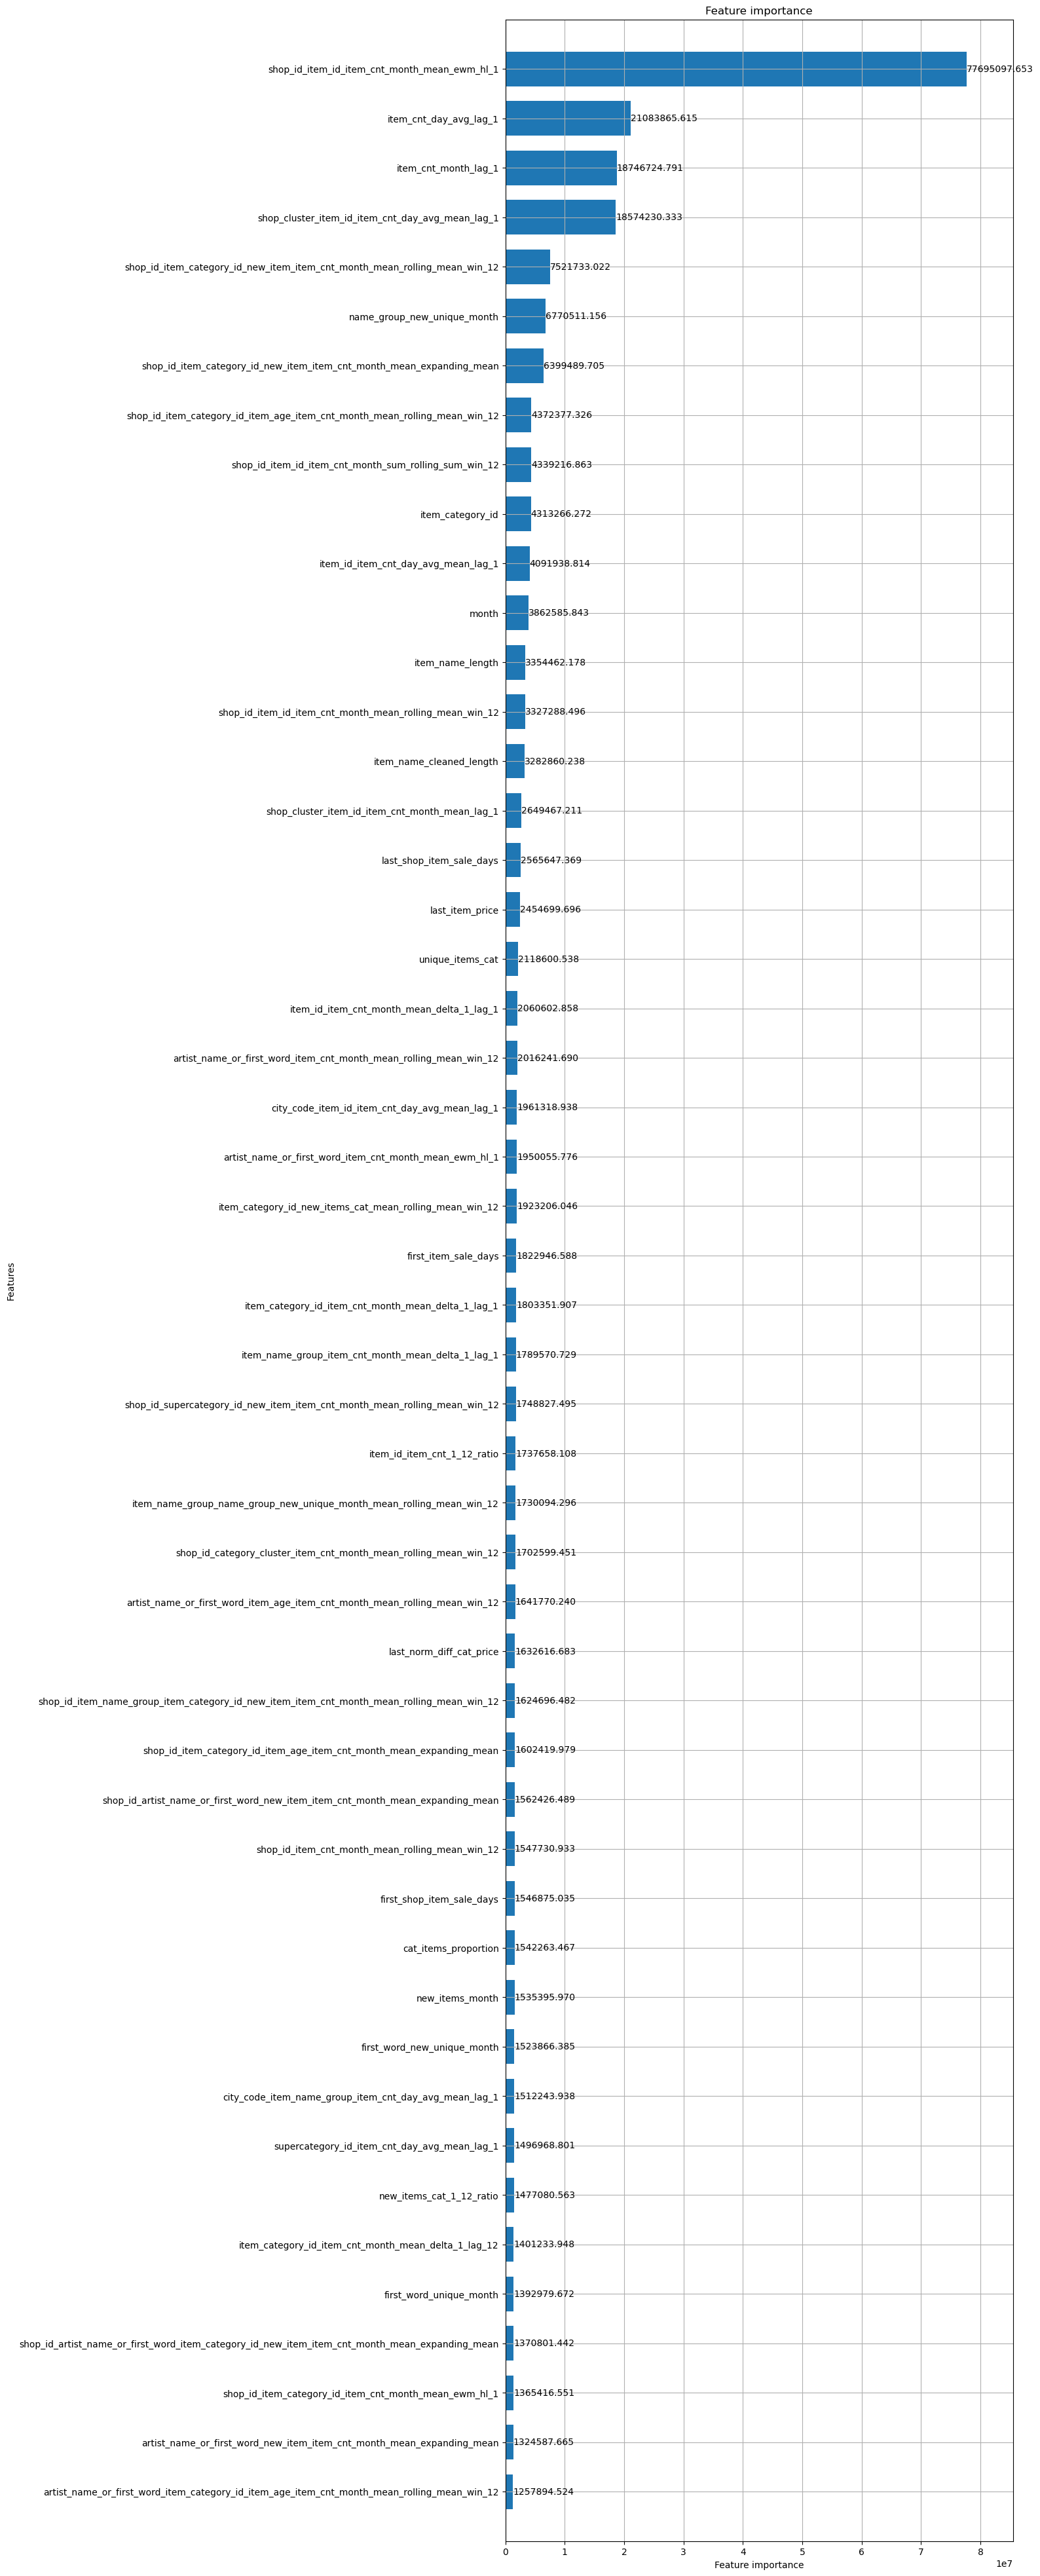

In [ ]:
_ = lgbm.plot_importance(lgbooster, figsize=(10,50), height=0.7, importance_type="gain", max_num_features=50)

In [ ]:
import joblib
_ = joblib.dump(lgbooster, "trained_lgbooster.pkl") #lgbm 학습 객체 저장

In [ ]:
from sklearn.metrics import mean_squared_error
# sklearn.metrics.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)
np.sqrt(mean_squared_error(y_test, lgbooster.predict(X_test.drop(columns=dropcols)).clip(0,20)))

# 그냥 점수를 때리면 0.9315... 가 나오지만 앞에서 inner join 했기 때문에 제출점수는 더 향상되어 0.844 점입니다.
# LGBM model 은 특수한 처리를 거치지 않으면 r2 스코어를 지원하지 않습니다. (LGBM은 output이 mean Y를 예측하기 때문에 (과적합 방지))

0.9315767302795266

In [ ]:
test_orig = pd.read_csv("C:/Users/student/Desktop/lab/competitive-data-science-predict-future-sales/test.csv")
test_orig.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## XGBOOST

In [ ]:
matrix = pd.read_pickle("C:/Users/student/Desktop/lab/checkpoint_final_0.84.pkl")
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)
keep_from_month = 2
test_month = 34
test = matrix.loc[matrix.date_block_num==test_month, :]
X_test = test.drop(columns="item_cnt_month")
y_test = test.item_cnt_month
del(matrix)

In [ ]:
params = {
    "cat_smooth": 45.01680827234465,
    "min_child_samples": 27,
    "min_child_weight": 0.021144950289224463,
    "max_bin": 214,
    "learning_rate": 0.01,
    "subsample_for_bin": 300000,
    "min_data_in_bin": 7,
    "colsample_bytree": 0.8,
    "subsample": 0.6,
    "subsample_freq": 5,
    "n_estimators": 750,
}

In [ ]:
from xgboost import XGBRegressor
from xgboost import plot_importance

def fit_booster_XGB(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    params=None,
    test_run=False,
    categoricals=[],
    dropcols=[],
    early_stopping=True,
):
    if params is None:
        params = {"learning_rate": 0.1, "subsample_for_bin": 300000, "n_estimators": 50}

    early_stopping_rounds = None
    if early_stopping == True:
        early_stopping_rounds = 30

    if test_run:
        eval_set = [(X_train, y_train)]
    else:
        eval_set = [(X_train, y_train), (X_test, y_test)]

    booster = xgb.XGBRegressor(**params)

    categoricals = [c for c in categoricals if c in X_train.columns]

    booster.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_metric=["rmse"],
        verbose=100,
        categorical_feature=categoricals,
        early_stopping_rounds=early_stopping_rounds,
    )

    return booster

In [ ]:
categoricals = [
    "item_category_id",
    "month",
]

xgbooster = fit_booster_XGB(
    X_train,
    y_train,
    X_valid,
    y_valid,
    params=params,
    test_run=False,
    categoricals=categoricals,
)

In [ ]:
_ = joblib.dump(xgbooster, "trained_xgbooster.pkl") #xgb 학습 객체 저장

# Predict
데이터 매트릭스에서 테스트 항목을 분할하고 훈련된 모델을 사용하여 대상을 예측합니다.

In [ ]:
matrix = pd.read_pickle("C:/Users/student/Desktop/lab/checkpoint_final_0.84.pkl")
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)
keep_from_month = 2
test_month = 34
test = matrix.loc[matrix.date_block_num==test_month, :]
X_test = test.drop(columns="item_cnt_month")
y_test = test.item_cnt_month
del(matrix)

In [ ]:
lgbooster.predict(X_test.drop(columns=dropcols)).clip(0,20)

array([0.58516244, 2.1397684 , 0.99239138, ..., 0.05422533, 0.01371144,
       0.04538276])

In [ ]:
lgbooster.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('rmse', 0.6234150516353224),
                          ('l2', 0.3886463266054717)]),
             'valid_1': OrderedDict([('rmse', 0.7091843526552005),
                          ('l2', 0.5029424460509758)])})

In [ ]:
X_test["item_cnt_month"] = lgbooster.predict(X_test.drop(columns=dropcols)).clip(0, 20)
# 예측치를 주어진 템플릿과 통합
test_orig = pd.read_csv("C:/Users/student/Desktop/lab/competitive-data-science-predict-future-sales/test.csv")
test = test_orig.merge(
    X_test[["shop_id", "item_id", "item_cnt_month"]],
    on=["shop_id", "item_id"],
    how="inner",
    copy=True,
)
# test_orig 에 inner join 했으므로 shop id, item id 가 일치하는 X_test만 합칩니다.
# 제출 인덱스가 원본과 일치하는지 확인합니다.
assert test_orig.equals(test[["ID", "shop_id", "item_id"]])  # assert [조건], [오류메시지]  이 조건이 True이면 그대로 코드가 진행되고, False라면 AssertionError가 발생합니다. 
test[["ID", "item_cnt_month"]].to_csv("submission.csv", index=False)

# 블렌딩 작업 (예측값을 변수로 활용하는 앙상블 테크닉: Blending)

Blending 의 프로세스  



1. Traning/Validation/Test set 을 나눈다. 

2. Training set 에 모델 피팅을 한다. 

3. Validation/Test set 에 대해 예측을 한다. 

4. Validation set 과 Validation set 에 대한 예측이 새로운 모델을 만드는 데에 사용된다.

5. 4의 모델을 최종 Test set 에 대한 예측을 하는데 사용된다. 

### 예측 데이터 스택

In [ ]:
y_train_pred = []
y_val_pred = []
y_test_pred = []

In [ ]:
yhat_train_lgb = fit_booster.predict(X_train).clip(0,20)
yhat_valid_lgb = fit_booster.predict(X_valid).clip(0,20)
yhat_test_lgb = fit_booster.predict(X_test).clip(0,20)

In [ ]:
yhat_train_xgb = fit_booster_XGB.predict(X_train).clip(0,20)
yhat_valid_xgb = fit_booster_XGB.predict(X_valid).clip(0,20)
yhat_test_xgb = fit_booster_XGB.predict(X_test).clip(0,20)

In [ ]:
y_train_pred.append(yhat_train_lgb)
y_val_pred.append(yhat_valid_lgb)
y_test_pred.append(yhat_test_lgb)
y_train_pred.append(yhat_train_xgb)
y_val_pred.append(yhat_valid_xgb)
y_test_pred.append(yhat_test_xgb)

In [ ]:
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error

def stacking_preds(meta_model, train_preds, val_preds, test_preds, y_train, y_val):
    stacked_train_predictions=np.column_stack(train_preds)
    stacked_val_predictions=np.column_stack(val_preds)
    stacked_test_predictions=np.column_stack(test_preds)
    # column_stack : 1차원 벡터를 열벡터로 인식하여 연결
    # fit meta model on stacked predictions
    meta_model.fit(stacked_train_predictions, y_train)
    print('RMSE =',np.sqrt(mean_squared_error(meta_model.predict(stacked_val_predictions).clip(0, 20), y_val)))
    return meta_model.predict(stacked_test_predictions).clip(0, 20)

In [ ]:
test_preds = stacking_preds(meta_model, y_train_pred, y_val_pred, y_test_pred, y_train, y_valid)

In [ ]:
X_test["item_cnt_month"] = test_preds
test_orig = pd.read_csv("C:/Users/student/Desktop/lab/competitive-data-science-predict-future-sales/test.csv")
test_2 = test_orig.merge(
    X_test[["shop_id", "item_id", "item_cnt_month"]],
    on=["shop_id", "item_id"],
    how="inner",
    copy=True,
)

# test_orig 에 inner join 했으므로 shop id, item id 가 일치하는 X_test만 합칩니다.
# 제출 인덱스가 원본과 일치하는지 확인합니다.

assert test_orig.equals(test[["ID", "shop_id", "item_id"]])  # assert [조건], [오류메시지]  이 조건이 True이면 그대로 코드가 진행되고, False라면 AssertionError가 발생합니다. 
test[["ID", "item_cnt_month"]].to_csv("submission.csv", index=False)